In [151]:
%matplotlib inline

In [155]:
import numpy as np
import matplotlib.pyplot as plt
import qrcode



In [156]:
data = "halo ini data terbuka"
SECRET = "RAHASIA"
img = qrcode.make(data,version=3,error_correction=qrcode.constants.ERROR_CORRECT_H)
img = np.asanyarray(img).astype('uint8')*255

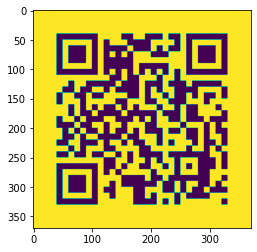

In [157]:
plt.imshow(img)

In [142]:
def generate_watermark(quant,secret,size=(100,100),rprop=100):
    seed = 0
    dist  = [0 if i==0 else int(i*256/quant)-1 for i in range(quant+1)]
    np.random.seed(abs(hash(secret))%2**32)
    p=np.random.choice([i for i in range(rprop)],size = 17)
    p=p/p.sum()
    watermark = np.random.choice(dist,size=size,p=p)
    return watermark.astype('uint8')

In [153]:
watermark = generate_watermark(16,"rahasia")
length = watermark.shape[0] + 8
loc = img.shape[0]//2 - length//2
wm = np.ones((length,length),dtype='uint8')*255
wm[4:-4,4:-4] = watermark
img[loc:loc+length,loc:loc+length]=wm

(-0.5, 369.5, 369.5, -0.5)

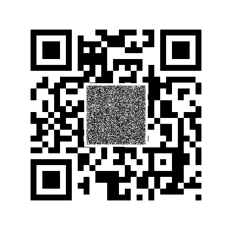

In [154]:
plt.imshow(img,cmap="gray")
plt.axis('off')

(array([2084.,  948.,  838., 1180.,    0.,  391.,  999.,  243.,   48.,
         626.,    0.,    8., 1310.,  148.,  723.,  454.]),
 array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
        0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
        1.    ]),
 <BarContainer object of 16 artists>)

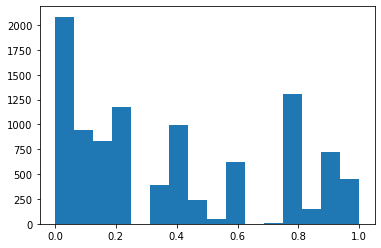

In [92]:
plt.hist(watermark.ravel()/watermark.max(),bins=16)